In [2]:
!wget http://cs301.pintoenterprisetech.com/out.csv

--2021-11-12 14:58:07--  http://cs301.pintoenterprisetech.com/out.csv
Resolving cs301.pintoenterprisetech.com (cs301.pintoenterprisetech.com)... 157.245.119.43, 2604:a880:800:10::904:6001
Connecting to cs301.pintoenterprisetech.com (cs301.pintoenterprisetech.com)|157.245.119.43|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91702 (90K) [text/csv]
Saving to: ‘out.csv.1’

out.csv.1           100%[===================>]  89.55K  --.-KB/s    in 0.05s   

2021-11-12 14:58:07 (1.61 MB/s) - ‘out.csv.1’ saved [91702/91702]



In [3]:
import pandas as pd
import datetime

In [4]:
df = pd.read_csv("out.csv")

In [5]:
GMEdf = df.drop(['timekey', 'ticker'], axis=1).rename(columns={"timestamp" : "ds", "avg(sentiment)" : "avg(sentiment)"})

In [6]:
GMEdf.head()

,ds,avg(sentiment)
0,2021-10-31 02:48:20,0.020940
1,2021-10-31 02:51:21,0.339265
2,2021-10-31 03:03:52,0.375158
3,2021-10-31 03:10:07,0.181590
4,2021-10-31 03:20:05,-0.014369


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
GMEpricesDf = pd.read_csv('/content/drive/MyDrive/GME(2).csv')
GMEpricesDf['Date'] = pd.to_datetime(GMEpricesDf['Date'])
GMEpricesDf.set_index('Date', inplace=True)
GMEpricesDf = GMEpricesDf.resample('D').pad()
def populate_target_prices(ds):
  date = datetime.datetime.strptime(ds, "%Y-%m-%d %H:%M:%S")
  date1 = date+datetime.timedelta(days=1)
  if date.hour < 16:
    try:
      return GMEpricesDf.loc[date.strftime("%Y-%m-%d")]['Close']
    except:
      pass
  else:
    try:
      return GMEpricesDf.loc[date1.strftime("%Y-%m-%d")]['Close']
    except:
      pass
  #https://www.programiz.com/python-programming/datetime/strptime

In [12]:
GMEpricesDf

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-12,11.740000,11.870000,10.970000,11.130000,11.130000,4353300
2020-11-13,11.360000,11.550000,11.000000,11.010000,11.010000,3535900
2020-11-14,11.360000,11.550000,11.000000,11.010000,11.010000,3535900
2020-11-15,11.360000,11.550000,11.000000,11.010000,11.010000,3535900
2020-11-16,11.160000,12.660000,10.720000,12.060000,12.060000,9774800
...,...,...,...,...,...,...
2021-11-08,212.500000,225.039993,212.009995,218.639999,218.639999,2157900
2021-11-09,222.000000,223.490005,204.440002,206.600006,206.600006,1845300
2021-11-10,202.119995,207.389999,196.500000,199.190002,199.190002,1309400


In [15]:
GMEdf['test'] = GMEdf['ds'].apply(populate_target_prices)
GMEdf = GMEdf.ffill()

In [16]:
GMEdf

,ds,avg(sentiment),test
0,2021-10-31 02:48:20,0.020940,183.509995
1,2021-10-31 02:51:21,0.339265,183.509995
2,2021-10-31 03:03:52,0.375158,183.509995
3,2021-10-31 03:10:07,0.181590,183.509995
4,2021-10-31 03:20:05,-0.014369,183.509995
...,...,...,...
1535,2021-11-10 18:30:09,0.202564,204.320007
1536,2021-11-10 18:40:02,0.188525,204.320007
1537,2021-11-10 18:50:03,0.394811,204.320007
1538,2021-11-10 19:00:00,0.319333,204.320007


In [17]:
!pip install prophet

     |████████████████████████████████| 65 kB 2.3 MB/s 
     |████████████████████████████████| 49 kB 4.3 MB/s 
     |████████████████████████████████| 214 kB 19.3 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640208 sha256=c33aa5b8ffbd85640039360d22965085b7309050439b2edd7aee95eeff0b3a2b
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [18]:
from prophet import Prophet

First get future sentiment values

In [19]:
sentiment_m = Prophet(changepoint_prior_scale=0.01, seasonality_prior_scale=.1, seasonality_mode='additive')
sentiment_m.fit(GMEdf[['ds', 'avg(sentiment)']].rename(columns={'ds':'ds', 'avg(sentiment)':'y'}))

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [20]:
sentiment_future = sentiment_m.make_future_dataframe(periods=100, freq='H')
sentiment_future.tail()
sentiment_forecast = sentiment_m.predict(sentiment_future)
sentiment_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1635,2021-11-14 19:10:02,0.348573,0.195252,0.505622
1636,2021-11-14 20:10:02,0.348671,0.193159,0.502319
1637,2021-11-14 21:10:02,0.352447,0.203793,0.510664
1638,2021-11-14 22:10:02,0.356906,0.200535,0.501443
1639,2021-11-14 23:10:02,0.359991,0.215717,0.495962


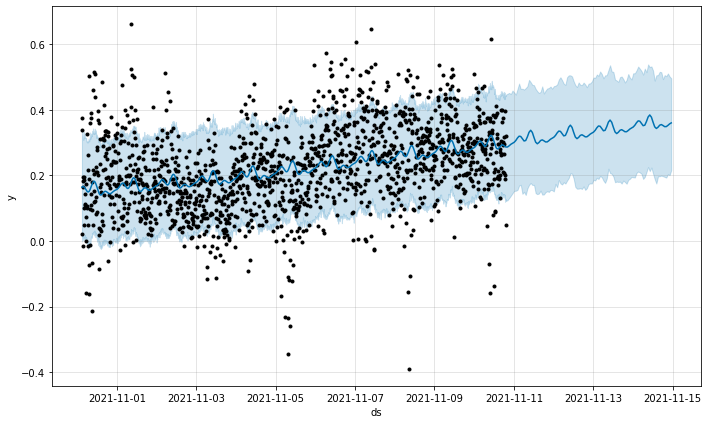

In [21]:
fig1 = sentiment_m.plot(sentiment_forecast)

In [22]:
sentiment_forecast.index = pd.to_datetime(sentiment_forecast.ds)

Add sentiment as additional regressor

In [23]:
m = Prophet(changepoint_prior_scale=0.005, seasonality_prior_scale=.1, seasonality_mode='additive')
m.add_regressor('avg(sentiment)', prior_scale=m.seasonality_prior_scale, standardize=True, mode='additive')
m.fit(GMEdf[['ds', 'test', 'avg(sentiment)']].rename(columns={'ds':'ds', 'test':'y'}))


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [24]:
def fillsentiment(ds):
  return sentiment_forecast.loc[pd.to_datetime(ds), 'yhat']

In [25]:
future = m.make_future_dataframe(periods=100, freq='H')
future['avg(sentiment)'] = future['ds'].apply(fillsentiment)
future.tail()

,ds,avg(sentiment)
1635,2021-11-14 19:10:02,0.348573
1636,2021-11-14 20:10:02,0.348671
1637,2021-11-14 21:10:02,0.352447
1638,2021-11-14 22:10:02,0.356906
1639,2021-11-14 23:10:02,0.359991


In [26]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1635,2021-11-14 19:10:02,167.138802,154.109674,179.941641
1636,2021-11-14 20:10:02,166.367494,152.236553,179.240598
1637,2021-11-14 21:10:02,165.746597,151.726898,178.874469
1638,2021-11-14 22:10:02,165.391203,151.016208,178.770768
1639,2021-11-14 23:10:02,165.174166,150.177919,178.851253


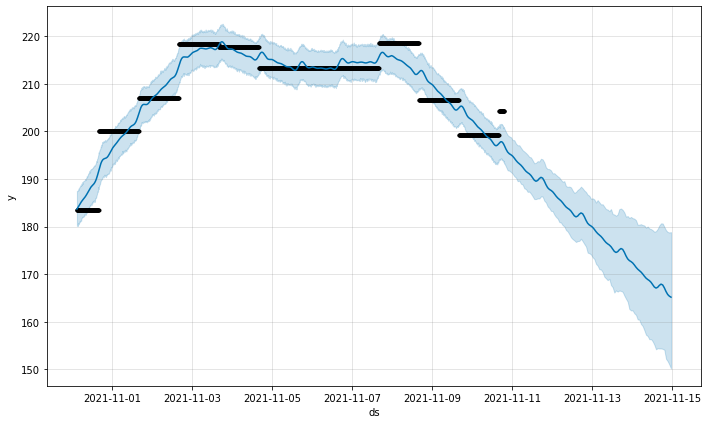

In [27]:
fig1 = m.plot(forecast)

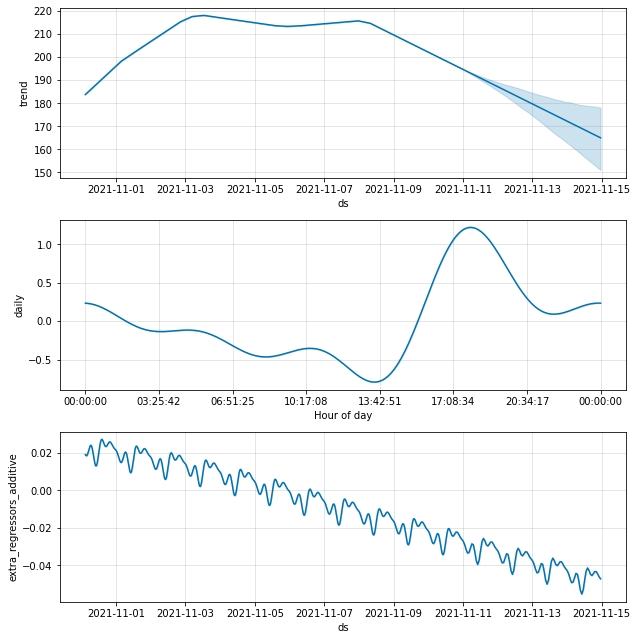

In [28]:
fig2 = m.plot_components(forecast)

In [29]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [30]:
plot_components_plotly(m, forecast)